In [181]:
import os, os.path, shutil
from os import path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# for machine learning
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# for deep learning

import tensorflow as tf
import keras
from keras.utils import plot_model 
from keras import backend as K 
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import  ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix



In [182]:
Dataset_dir ='./chest_Xray'

train_dir =Dataset_dir+'/train/'
test_dir =Dataset_dir+'/test/'
val_dir = Dataset_dir+'/val/'

train_NORMAL_dir = train_dir+'/NORMAL/'
train_PNEUMONIA_dir = train_dir+'/PNEUMONIA/'

There are 1338, NORMAL images
There are 3875, PNEUMONIA images


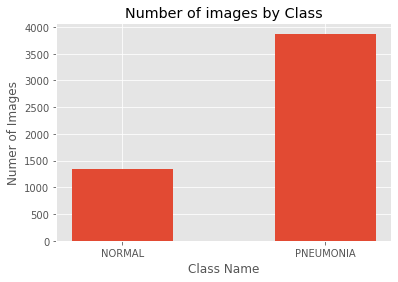

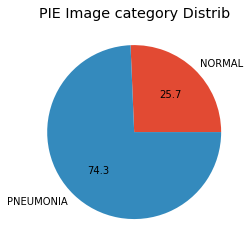

('./chest_Xray/train/', './chest_Xray/val/', './chest_Xray/test/')

In [183]:
# Load and copy data
def load_data():
    images_NORMAL = [file for file in os.listdir(train_NORMAL_dir) if file.endswith('.jpeg')]
    images_PNEUMONIA = [file for file in os.listdir(train_PNEUMONIA_dir) if file.endswith('.jpeg')]

    print(f'There are {len(images_NORMAL)}, NORMAL images')
    print(f'There are {len(images_PNEUMONIA)}, PNEUMONIA images')
     #Plot number of classes to identify imbalances
    number_classes = {'NORMAL':len(images_NORMAL),
                    'PNEUMONIA':len(images_PNEUMONIA)}

    plt.bar(number_classes.keys(), number_classes.values(), width = 0.5)
    plt.title("Number of images by Class")
    plt.xlabel("Class Name")
    plt.ylabel("Numer of Images")   
    plt.show()
   
    plt.pie(x=number_classes.values(), labels=number_classes.keys(), autopct='%1.1f')
    plt.title("PIE Image category Distrib")
    plt.show()

    return train_dir, val_dir, test_dir

load_data()

In [184]:
def data_generator(train_datagen, train_dir,val_datagen, val_dir,test_datagen, test_dir):
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir,val_dir,test_dir]
    generator_lst = []
    
    for generator, directory in zip(datagen_lst, directory_lst):
    
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (64,64),
                                         batch_size = 128,
                                         color_mode = 'grayscale',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 1)
        generator_lst.append(g)
    
    return generator_lst    

In [185]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = data_generator(
    train_datagen, train_dir,
    val_datagen, val_dir,
    test_datagen, test_dir)

Found 5213 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [186]:

def model_1():
    cnn = Sequential()
    
    cnn.add(InputLayer(input_shape=(64,64,1)))
    # Convolution
    cnn.add(Conv2D(32, (3, 3), activation='relu',input_shape=(64,64,3)))
    
    # Pooling
    cnn.add(MaxPooling2D((2, 2))) 
    cnn.add(BatchNormalization(axis=1))
    
    #  Convolution 2
    cnn.add(Conv2D(32, (3, 3),activation='relu'))
    #  Pooling 2
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(BatchNormalization(axis=1))
    
    cnn.add(Flatten()) #convert 3D features map in 1D
    cnn.add(Dense(activation='relu',units =128))
    cnn.add(Dense(activation='sigmoid',units=1))
    adam = Adam(learning_rate=0.0001)
    cnn.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc']) #// TODO check params doc model.compile()
    cnn.summary()
    
    return cnn


In [187]:
def LossOverEpochs(hist):
    plt.figure(figsize=(16, 9))
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Valid Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs fct')
    plt.show()



In [188]:
# plotting train and validation curve LOSS
def train_validation_loss(cnn_model):
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    fig = plt.figure(figsize = (8,5))
    plt.title("Loss over the epochs")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Epochs", size=14)
    plt.ylabel('Loss')
    plt.grid(True, linestyle='-.')
    plt.legend()
    plt.show()
    return plt
  

In [189]:
# plotting train and validation curve accuracy
def train_validation_acc(cnn_model):
    acc = cnn_model.history['acc']
    val_acc = cnn_model.history['val_acc']
    plt.figure(figsize = (8,6))
    plt.title("Train Validation Accuracy")
    plt.plot(cnn_model.history['acc'])
    plt.plot(cnn_model.history['val_acc'])
    plt.xlabel("Epochs", size=12)
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='-.')
    # plt.tick_params(labelcolor='r', labelsize='medium', width=3)
    plt.legend(['acc','val_acc'])
    plt.show()  
    return plt

In [190]:
def testaccuracy(cnn_model):
    plt.figure(figsize=(8, 6))
    plt.title('TEST Accuracy scores TEST')
    plt.plot(cnn_model.history['acc'])
    plt.plot(cnn_model.history['val_acc'])
    plt.legend(['acc', 'val_acc'])
    plt.show()
    return plt

In [191]:
def train_accu(h):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(h.history["acc"], label='train_acc')
    plt.plot(h.history["val_acc"], label='val_acc')
    plt.title(' TRAINING accuracy ')
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()  

In [192]:
def cm_plot_1(cnn):
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator,steps=len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    y_pred1 = np.argmax(Y_pred, axis=1)
    cm2 = confusion_matrix(y_true,y_pred)
    print('classification report:\n',classification_report(y_true, y_pred))
    disp = ConfusionMatrixDisplay(cm2, display_labels=test_generator.classes)
    disp.from_predictions(y_true,y_pred)
    plt.title("Confusion Matrix", fontsize = 22) 
    plt.xticks(range(2), ['Normal','Pneumonia'], fontsize = 16)
    plt.yticks(range(2), ['Normal','Pneumonia'], fontsize = 16)
    plt.show()
    


In [193]:
def ROC_curve_AUC_score(cnn):
    fig = plt.figure(figsize=(10, 8))
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    plt.show()
    

In [194]:
def Summary_Stats(cnn):
    
    
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps= len(test_generator))
    y_pred = (Y_pred>0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    cm = confusion_matrix(y_true, y_pred)
    
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    #ravel, which is used to change a 2-dimensional array or a multi-dimensional array into a contiguous flattened array. 
    #The returned array has the same data type as the source array or input array.
    accuracy = (TP + TN) / np.sum(cm) 
    precision = TP / (TP+FP) 
    recall =  TP / (TP+FN)
    specificity = TN / (TN+FP) 
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(f'{stats_summary}\n')


In [195]:
def allgraph(h):
    plt.style.use('ggplot')
    plt.figure(figsize=(16,9))
    plt.plot(h.history["loss"], label='train_loss')
    plt.plot(h.history["val_loss"], label='val_loss')
    plt.plot(h.history["acc"], label='train_acc')
    plt.plot(h.history["val_acc"], label='val_acc')
    plt.title('MODEL TRAINING')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()  
   
    


In [196]:
def training_graph( modelfit):
    
    plt.figure(figsize=(16, 9))
    plt.plot(modelfit.epoch, modelfit.history['acc'])
    plt.title('Model Accuracy')
    plt.legend(['train'], loc='upper left')
    # plt.show()
    
    plt.figure(figsize=(16, 9))
    plt.plot(modelfit.epoch, modelfit.history['loss'])
    plt.title('Model Loss')
    plt.legend(['train'], loc='upper left')
    # plt.show()

    plt.figure(figsize=(16, 9))
    plt.plot(modelfit.epoch, modelfit.history['val_acc'])
    plt.title('Model Validation Accuracy')
    plt.legend(['train'], loc='upper left')
    # plt.show()

    plt.figure(figsize=(16, 9))
    plt.plot(modelfit.epoch, modelfit.history['val_loss'])
    plt.title('Model Validation Loss')
    plt.legend(['train'], loc='upper left')
    # plt.show()
   

There are 1338, NORMAL images
There are 3875, PNEUMONIA images


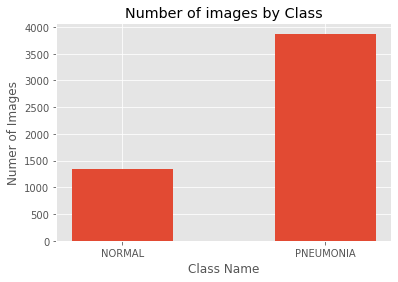

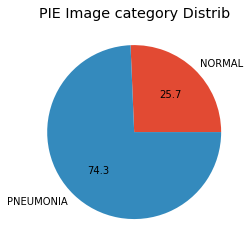

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_40 (Bat  (None, 31, 31, 32)       124       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                     

41/41 [==============================] - 41s 991ms/step - loss: 0.0743 - acc: 0.9726 - val_loss: 0.3644 - val_acc: 0.8878
Epoch 50/50
41/41 [==============================] - 47s 1s/step - loss: 0.0653 - acc: 0.9777 - val_loss: 0.4614 - val_acc: 0.8462


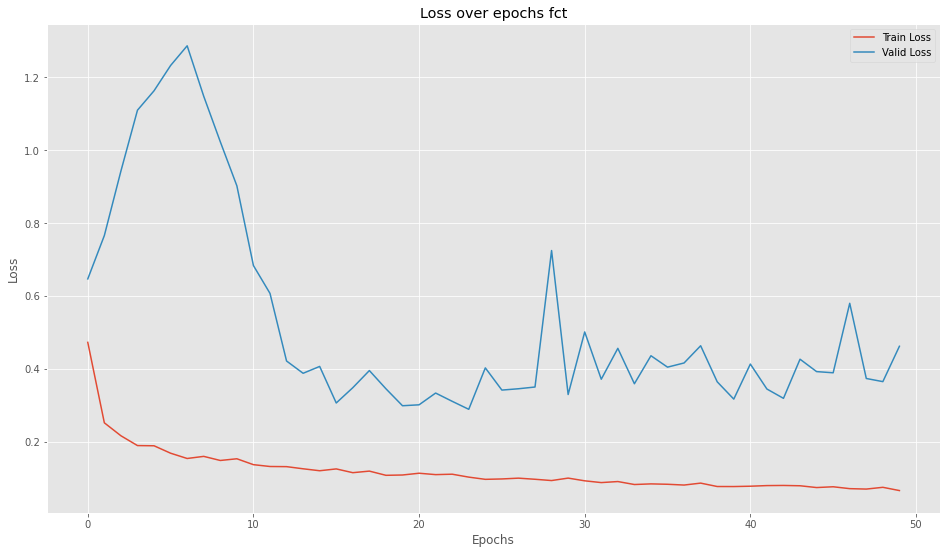

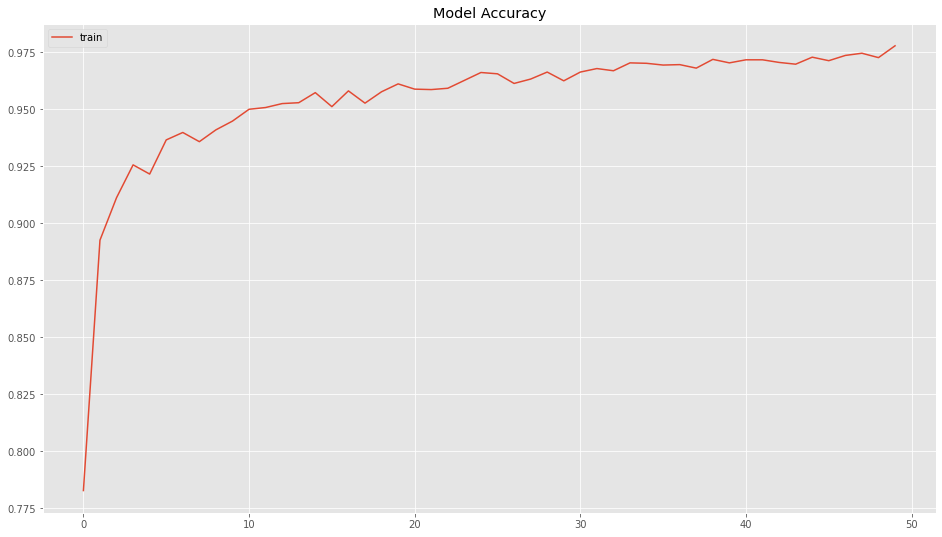

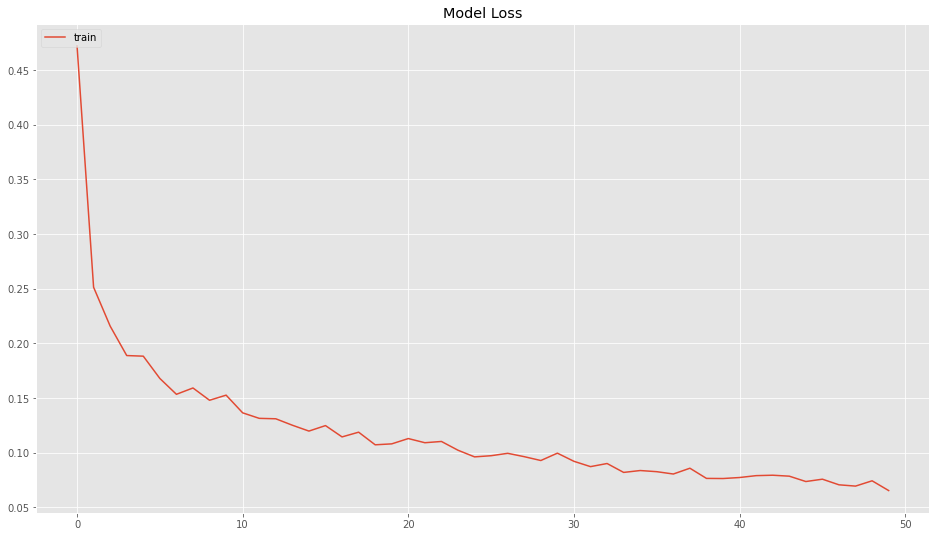

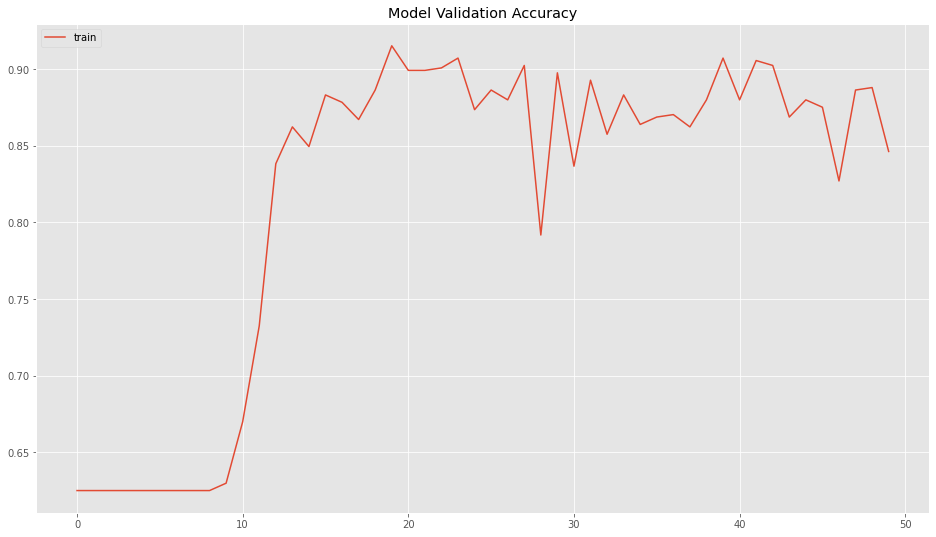

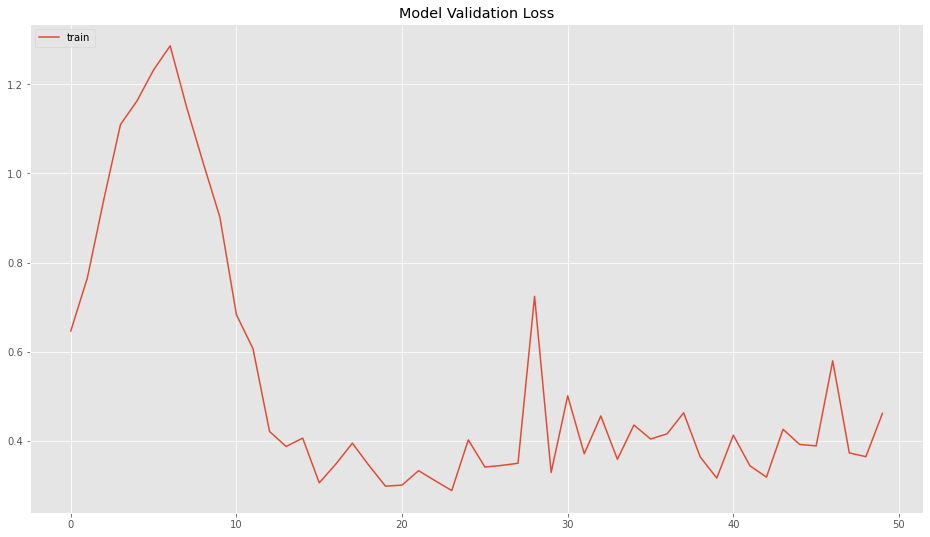

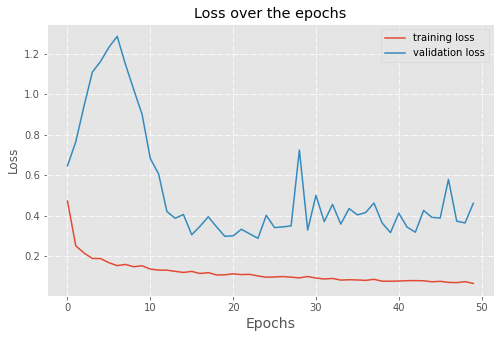

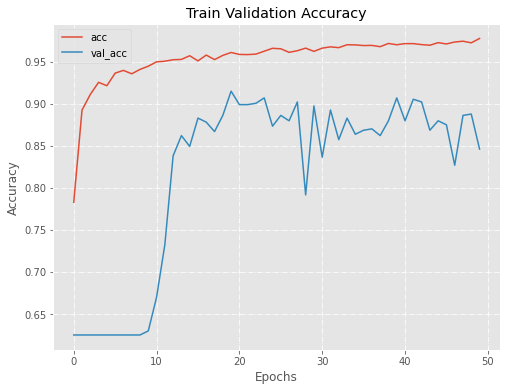

5/5 [==============================] - 4s 527ms/step
classification report:
               precision    recall  f1-score   support

           0       0.94      0.63      0.75       234
           1       0.81      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.85      0.84       624



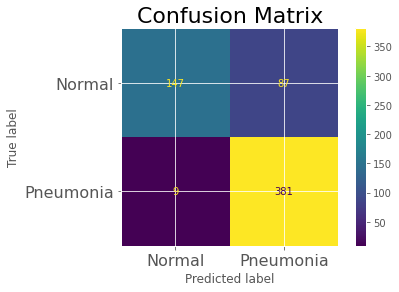

5/5 [==============================] - 4s 583ms/step


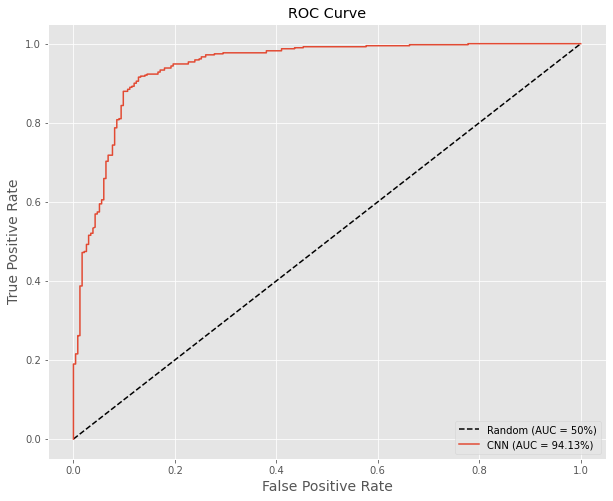

5/5 [==============================] - 4s 598ms/step
[Summary Statistics]
Accuracy = 84.62% | Precision = 81.41% | Recall = 97.69% | Specificity = 62.82% | F1 Score = 88.81%



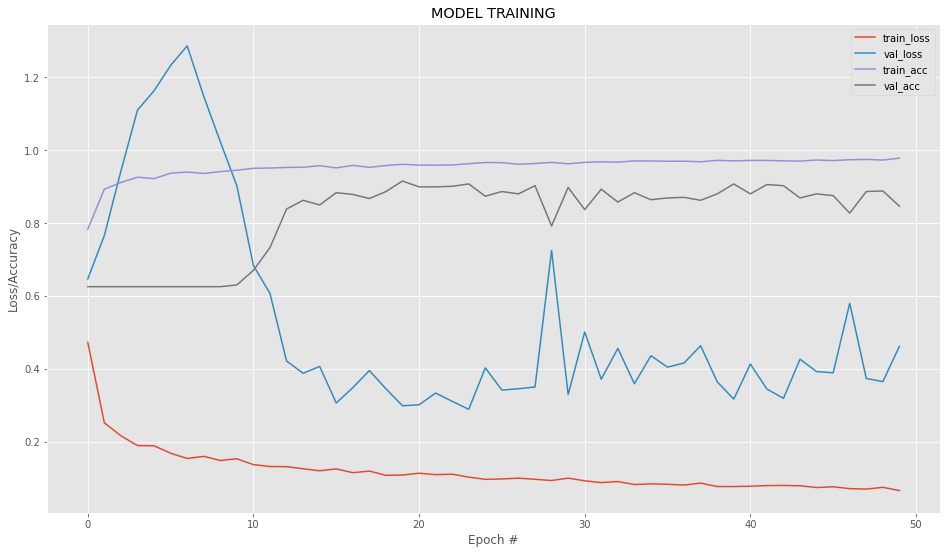

In [197]:
def Runner():
    
    load_data()
    
    cnn = model_1()
   
    
    cnn_hist = cnn.fit(train_generator,epochs = 50, steps_per_epoch=len(train_generator), validation_data=test_generator, validation_steps=len(test_generator), verbose=1)# callbacks=[early_stop, model_save,rlr]
    
  
    LossOverEpochs(cnn_hist) #// TODO:Train val loss + acc
    
#     cnn.evaluate(test_generator) #// TODO: A voir
    
    
    training_graph(cnn_hist) #//FIXME work
    
    train_validation_loss(cnn_hist) #//FIXME work
    
    train_validation_acc(cnn_hist) #//FIXME work
    
    cm_plot_1(cnn)   #//NOTE: run with train validation methode #//FIXME work
    
    ROC_curve_AUC_score(cnn) #//TODO work : checker doc

    Summary_Stats(cnn) #//FIXME work
    allgraph(cnn_hist)
    plt.show()
    
    
Runner()